In [1]:
import json
import os
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(os.path.join(sys.path[0], '../tooling/'))
from myeval import myevaluatemodels
from mymodels import nanodet
from mylogging import nanodet_parse

Collect training results

In [3]:
location = '../results/train_nanodet/'
logs = glob.glob(os.path.join(location,'*logs.txt'))
names = [strng[len(location):-9] for strng in logs] 

In [4]:
train_scores = []
for path in logs:
    train_scores.append(nanodet_parse(path))

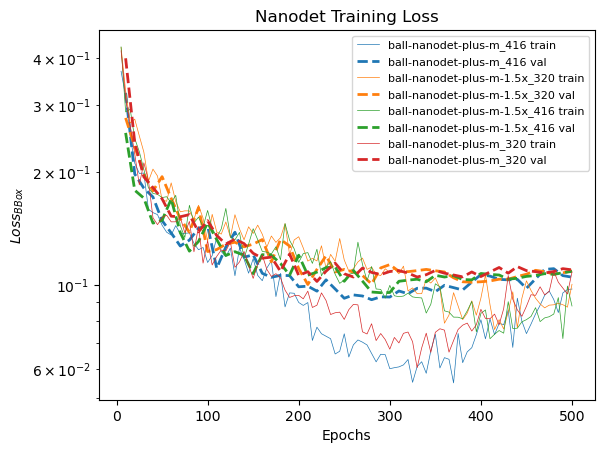

In [5]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

leg_list = []
for i, train_score in enumerate(train_scores):
    plt.plot(train_score[0], train_score[1], linestyle='-', color=colors[i], linewidth=0.5)
    leg_list.append(names[i] + " train")
    plt.plot(train_score[2], train_score[3], linestyle='--', color=colors[i], linewidth=2)
    leg_list.append(names[i] + " val")

plt.legend(leg_list, loc="upper right", fontsize="8", ncol=1)
plt.xlabel("Epochs")
plt.ylabel("$" + "Loss_{BBox}" + "$")
plt.yscale('log')
plt.title("Nanodet Training Loss")
plt.show()

Performance results

In [6]:
location = '../results/train_nanodet/'
dataset = 'coco_validation_sml_01_False_matchdrill'
load_dirs = glob.glob(os.path.join(location,'*.json'))
names = [strng[len(location):-11] for strng in load_dirs] 
model_score = []
model_lats = []

for i, path in enumerate(load_dirs):
    with open(path, 'r') as input_file:
        result_dict = json.load(input_file)
    model_score.append(result_dict[names[i]][dataset]['AP_{@[IoU=0.50:0.95]-all}'])
    model_lats.append(result_dict[names[i]][dataset]['latency'])

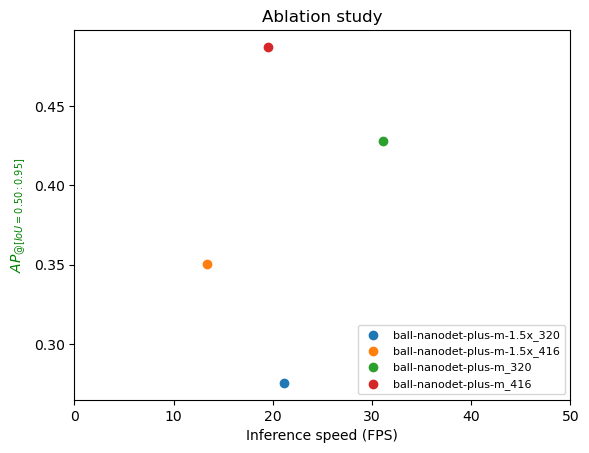

In [8]:
for i, name in enumerate(names):
    plt.scatter(model_lats[i], model_score[i])

plt.title("Ablation study")
plt.legend(names, loc="lower right", fontsize="8", ncol=1)
plt.xlabel('Inference speed (FPS)')
plt.xlim([0, 50])
plt.ylabel('$' + 'AP_{@[IoU=0.50:0.95]}' + '$', color='g')

plt.show()